In [2]:
import os
os.chdir('/workspace/FutureGPT2/src/')

import numpy as np
from torch import optim, nn, Tensor
from torch.nn import functional as F
import torch
import wandb
from transformers import GPT2Config, GPT2Model
import transformers
import lightning as L
from inspect import signature, _ParameterKind
import copy
import gc
import datasets
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import WandbLogger
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from itertools import repeat, product
from matplotlib import pyplot as plt
import matplotlib
from copy import deepcopy

from models.regression_model import *
from data.synthetic import *

%load_ext autoreload
%autoreload 2

In [85]:
ckpts = [
    '/workspace/checkpoints/SYNTH-GPT2-FIN_conv-10_shift-1_p-0.001_lr-0.001_n_embd-128_n_head-2_n_layer-2_activation_function-relu_global_step=58593.0_train_loss=0.00.ckpt',
    '/workspace/checkpoints/SYNTH-GPT2-FIN_conv-10_shift-1_p-0.01_lr-0.001_n_embd-128_n_head-2_n_layer-2_activation_function-relu_global_step=58593.0_train_loss=0.00.ckpt',
    '/workspace/checkpoints/SYNTH-GPT2-FIN_conv-10_shift-1_p-0.1_lr-0.001_n_embd-128_n_head-2_n_layer-2_activation_function-relu_global_step=58593.0_train_loss=0.00.ckpt',
    '/workspace/checkpoints/SYNTH-GPT2-FIN_conv-10_shift-1_p-0.3_lr-0.001_n_embd-128_n_head-2_n_layer-2_activation_function-relu_global_step=58593.0_train_loss=0.00.ckpt',
    '/workspace/checkpoints/SYNTH-GPT2-FIN_conv-10_shift-1_p-1_lr-0.001_n_embd-128_n_head-2_n_layer-2_activation_function-relu_global_step=58593.0_train_loss=0.01.ckpt',
    '/workspace/checkpoints/SYNTH-GPT2-COS_conv-10_shift-1_p-0.3_attn_pdrop-0.1_embd_pdrop-0.1_resid_pdrop-0.1_lr-0.001_n_embd-128_n_head-2_n_layer-2_activation_function-relu_global_step=58593.0_train_loss=0.04.ckpt',
]
myopic_ckpts = [
    '/workspace/checkpoints/SYNTH-GPT2-MYOPIC-COS_BETA0_conv-10_shift-1_p-1_lr-0.001_n_embd-128_n_head-2_n_layer-3_activation_function-relu_global_step=58593.0_train_loss=1.24.ckpt',
    '/workspace/checkpoints/SYNTH-GPT2-MYOPIC-COS_BETA0.0_conv-10_shift-1_p-0.3_lr-0.001_n_embd-128_n_head-2_n_layer-2_activation_function-relu_global_step=58593.0_train_loss=0.32.ckpt',
    '/workspace/checkpoints/SYNTH-GPT2-MYOPIC-COS_BETA0.0_conv-10_shift-1_p-0.1_lr-0.001_n_embd-128_n_head-2_n_layer-2_activation_function-relu_global_step=58593.0_train_loss=0.10.ckpt',
]
#ckpt = ckpts[3]
ckpt = '/workspace/checkpoints/SYNTH-GPT2-COS_conv-10_shift-1_p-1.0_lr-0.0001_n_embd-256_n_head-4_n_layer-2_activation_function-relu_decay-0.1_global_step=195312.0_train_loss=0.00.ckpt'

In [96]:
fixed_data_params = {
    'seq_len': 64,
}
free_data_params = {
    'conv': 10,
    'shift': 1,
    'p': 1.0,
}
data_params = {**fixed_data_params, **free_data_params}

ds = DataLoader(
    SyntheticSeqDataset(size=50_00, **data_params), 
    batch_size=512, 
    #num_workers=20,
    drop_last=True,
)

In [97]:
torch.set_grad_enabled(False)

In [98]:
class Intervene(nn.Module):
    '''
    Replaces (some subset of) input hidden_states with new_states
    Expects (batch_size, seq_length, embed_dim)
    '''
    def __init__(self, new_states):
        super().__init__()
        self.new_states = new_states

    def forward(self, hidden_states, **kwargs):
        for i in [0, 2]:
            assert self.new_states.shape[i] == hidden_states.shape[i]
        hidden_states[:,:self.new_states.shape[1],:] = self.new_states
        return hidden_states, None, None

In [99]:
def get_r2(ckpt, layer, lb=20, f=lambda x: torch.sin(10*x), by_pos=False, get_W=False, dim=128):
    ZZ, HH, HZ = 0, 0, 0
    model = LitGPT2RegModel.load_from_checkpoint(ckpt)
    for batch in tqdm(iter(ds)):
        x = batch['x'].to('cuda')
        out = model.model(
            inputs_embeds=model.model.wte(x),
            position_ids=torch.arange(0, x.shape[-2], 1, device=x.device),
            output_hidden_states=True,
        )
        H = out['hidden_states'][layer]
        # add bias
        H = torch.concat([H, torch.ones(H.shape[:-1] + (1,), device=H.device)], dim=-1)
        
        x = x[...,0]
        Z = []
        Z.append(f(x))
        for i in range(lb):
            x = x.roll(1, dims=1)
            x[:,0,] = 0
            Z.append(f(x))
        Z = torch.stack(Z, dim=2)
        
        H = H.cpu().numpy().astype(np.float64)
        Z = Z.cpu().numpy().astype(np.float64)
        
        if not by_pos:
            # flatten out batch_dim x seq_dim
            H = H.reshape((-1, H.shape[-1]))
            Z = Z.reshape((-1, Z.shape[-1]))
            ZZ += Z.T @ Z
            HH += H.T @ H
            HZ += H.T @ Z
        else:
            # move seq dim to front to do per-position R^2
            H = H.transpose((1, 0, 2))
            Z = Z.transpose((1, 0, 2))
            
            ZZ += Z.transpose((0, 2, 1)) @ Z
            HH += H.transpose((0, 2, 1)) @ H
            HZ += H.transpose((0, 2, 1)) @ Z
    HZT = HZ.transpose(0, 2, 1) if by_pos else HZ.T
    num = (HZT @ np.linalg.inv(HH + 1e-4 * np.eye(dim+1)) @ HZ)#.diagonal(axis1=1, axis2=2)
    denom = ZZ
    if not get_W:
        return num / denom
    else:
        return np.linalg.inv(HH + 1e-4 * np.eye(dim+1)) @ HZ

In [100]:
W = get_r2(ckpt, 1, get_W=True, dim=256)[:,[0]]

  0%|          | 0/9 [00:00<?, ?it/s]

In [101]:
r2 = get_r2(ckpt, 1, dim=256)

  0%|          | 0/9 [00:00<?, ?it/s]

In [102]:
r2[0][0]

0.9853382617500916

In [103]:
model = LitGPT2RegModel.load_from_checkpoint(ckpt)

In [104]:
xs = []
ys = []
yhats = []
for batch in tqdm(iter(ds)):
    x = batch['x'].to('cuda')
    x[:,:-2,0] = 0
    # out = model({'x': x})
    out = model.model(
        inputs_embeds=model.model.wte(x),
        position_ids=torch.arange(0, x.shape[-2], 1, device=x.device),
        output_hidden_states=True
    )
    h = out.hidden_states[1].cpu().numpy()
    y = model.model.unembed(out.last_hidden_state)
    yhat = (h * W[:-1, 0]).sum(axis=2) + W[-1, 0]
    idx = x[:,-1,1] > 0.5
    xs.append(x[:,-2,0][idx].cpu().numpy())
    ys.append(y[:,-1,0][idx].cpu().numpy())
    yhats.append(yhat[:,-2][idx.cpu().numpy()])
x = np.concatenate(xs)
y = np.concatenate(ys)
yhat = np.concatenate(yhats)

  0%|          | 0/9 [00:00<?, ?it/s]

[]

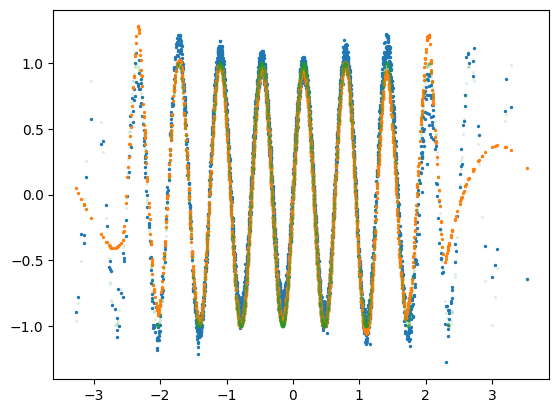

In [106]:
plt.scatter(x, y, s=2)
plt.scatter(x, yhat, s=2)
plt.scatter(x, np.sin(10*x), s=2, alpha=0.1)
plt.plot()

  0%|          | 0/9 [00:00<?, ?it/s]

0 c: -0.88 -0.02


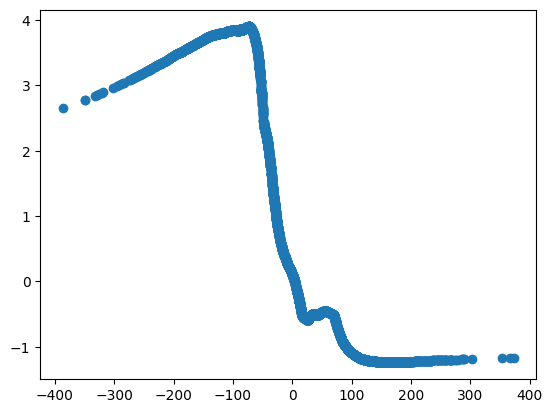

  0%|          | 0/9 [00:00<?, ?it/s]

1 c: 0.11 0.00


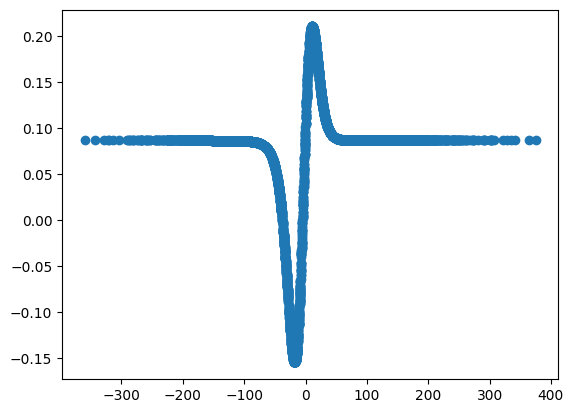

  0%|          | 0/9 [00:00<?, ?it/s]

2 c: 0.11 0.00


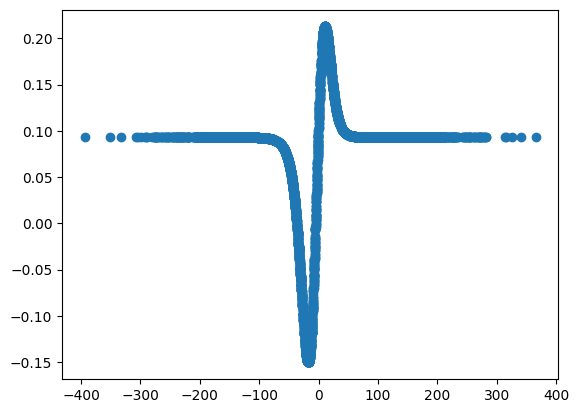

  0%|          | 0/9 [00:00<?, ?it/s]

3 c: 0.10 0.00


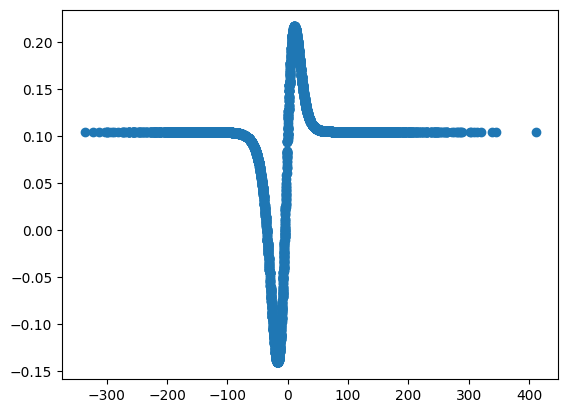

  0%|          | 0/9 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [108]:
corrs = []
betas = []
# for i in range(1, 20):
# LAYER ONE INTERVENTION

n = -5
for i in range(20):
    #s = 5
    #vec = V.T[s] * S[s]
    vec = torch.Tensor(W.flatten()[:-1] / np.linalg.norm(W[:-1]) **2).to('cuda')   # last index is bias term
    cs = []
    ys = []
    intervene_model = deepcopy(model)
    for batch in tqdm(iter(ds)):
        x = batch['x'].to('cuda')
        x[:,:,0] = 0.
        out = model.model(
            inputs_embeds=model.model.wte(x),
            position_ids=torch.arange(0, x.shape[-2], 1, device=x.device),
            output_hidden_states=True
        )
        h = out.hidden_states[1]
        c = torch.normal(0, 100, (512, 1), device='cuda')
        h[:,n-i,:] += (c * vec)
        intervene_model.model.h[0] = Intervene(h)
        intervene_out = intervene_model({'x': x})
        idx = batch['x'][:,n,1] > 0.5
        cs.append(c.flatten()[idx].cpu().numpy())
        # out = model({'x': x})
        ys.append(intervene_out[:,n,0][idx].cpu().numpy())
    c = np.concatenate(cs)
    y = np.concatenate(ys)
    corr = np.corrcoef(c, y)[1, 0]
    beta = (c * y).sum() / (c * c).sum()
    corrs.append(corr)
    betas.append(beta)
    print(i, f'c: {corr:.2f}', f'{beta:.2f}')
    plt.scatter(c, y)
    plt.show()

In [331]:
x.shape

torch.Size([512, 64, 2])

  0%|          | 0/9 [00:00<?, ?it/s]

1 -0.7923697375061047


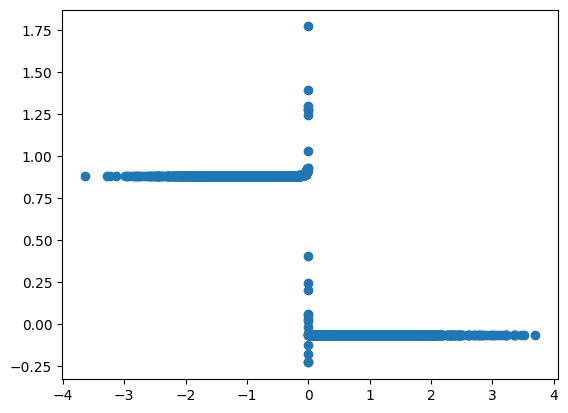

  0%|          | 0/9 [00:00<?, ?it/s]

1 -0.20379918462758886


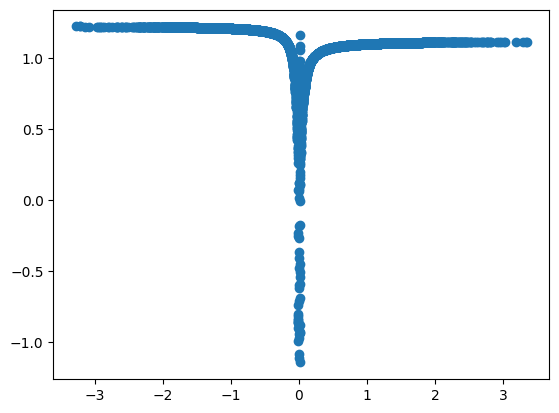

  0%|          | 0/9 [00:00<?, ?it/s]

1 0.8066059941498109


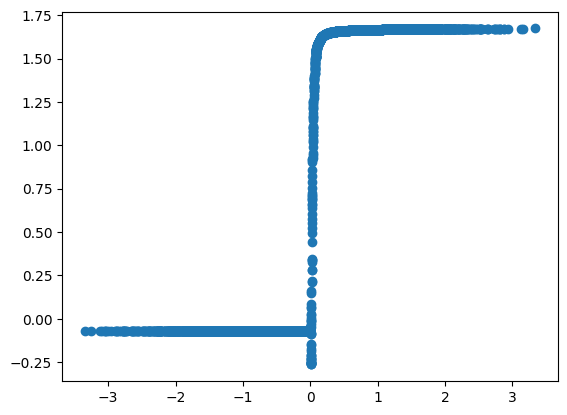

  0%|          | 0/9 [00:00<?, ?it/s]

1 0.8053563660971221


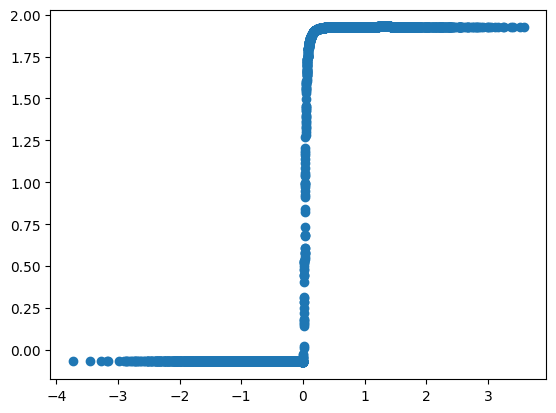

  0%|          | 0/9 [00:00<?, ?it/s]

1 0.7321563571764761


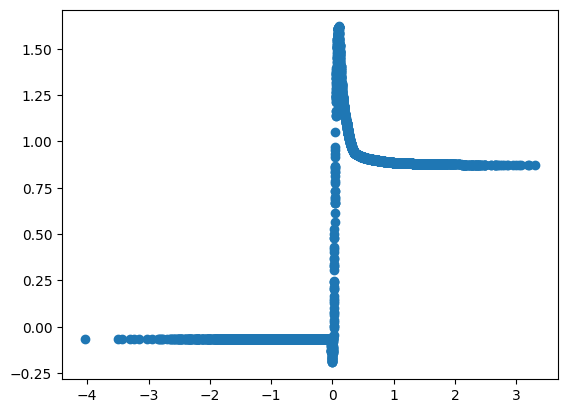

  0%|          | 0/9 [00:00<?, ?it/s]

1 -0.7634972409996685


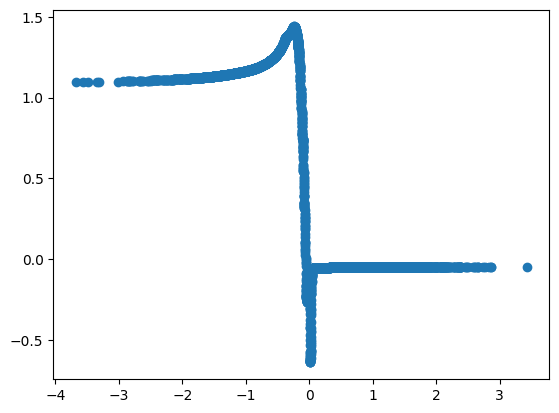

  0%|          | 0/9 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [335]:
# corrs = []
# for i in range(1, 20):
# LAYER ZERO INTERVENTION

i=1
n = -5
for s in range(20):
    #s = 5
    vec = V0.T[s] * S0[s]
    cs = []
    ys = []
    intervene_model = deepcopy(model)
    for batch in tqdm(iter(ds)):
        x = batch['x'].to('cuda')
        x[:,:,0] = 0
        c = torch.normal(0, 1, (512, 1), device='cuda')
        #x[:,n-i,0] += c.flatten()
        h = model.model.wte(x)
        h[:,n-i,:] += (c * vec)
        out = model.model(
            inputs_embeds=h,
            position_ids=torch.arange(0, x.shape[-2], 1, device=x.device),
            output_hidden_states=True
        ).last_hidden_state
        out = model.model.unembed(out)
        cs.append(c.flatten()[idx].cpu().numpy())
        # out = model({'x': x})
        ys.append(out[:,n,0][idx].cpu().numpy())
    c = np.concatenate(cs)
    y = np.concatenate(ys)
    corr = np.corrcoef(c, y)[1, 0]
    corrs.append(corr)
    print(i, corr)
    plt.scatter(c, y)
    plt.show()

In [245]:
c -= c.mean()

In [246]:
(c*(y - y.mean())).sum() / (c*c).sum()

0.0046075545

In [124]:
(c * torch.Tensor(W.flatten()[:-1]).to('cuda')).unsqueeze(1).shape

torch.Size([512, 1, 128])

In [109]:
out.max()

tensor(6.7696, device='cuda:0')

In [128]:
W.shape

(129, 1)

In [135]:
np.linalg.norm(W[:-1])

10.451243560582618

In [363]:
model = LitGPT2RegModel.load_from_checkpoint(ckpts[-1])

In [20]:
x = batch['x'].to('cuda')
out = model.model(
    inputs_embeds=model.model.wte(x),
    position_ids=torch.arange(0, x.shape[-2], 1, device=x.device),
    output_hidden_states=True,
    output_attentions=True,
)

In [21]:
out.attentions[0].shape

torch.Size([512, 1, 64, 64])

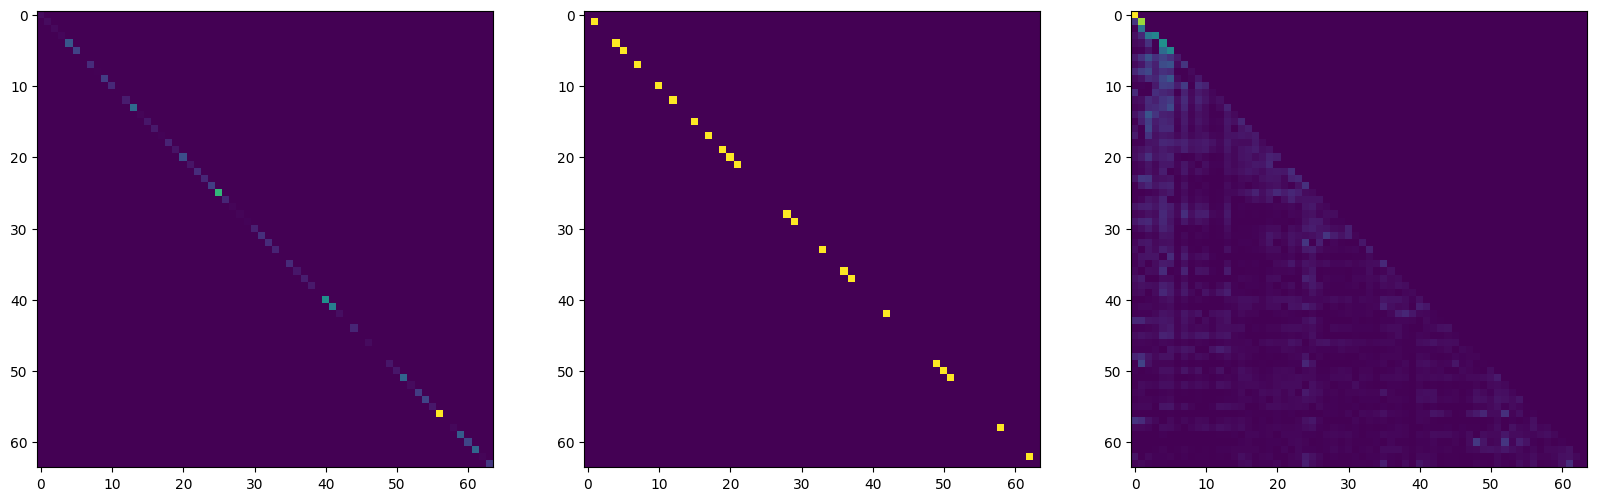

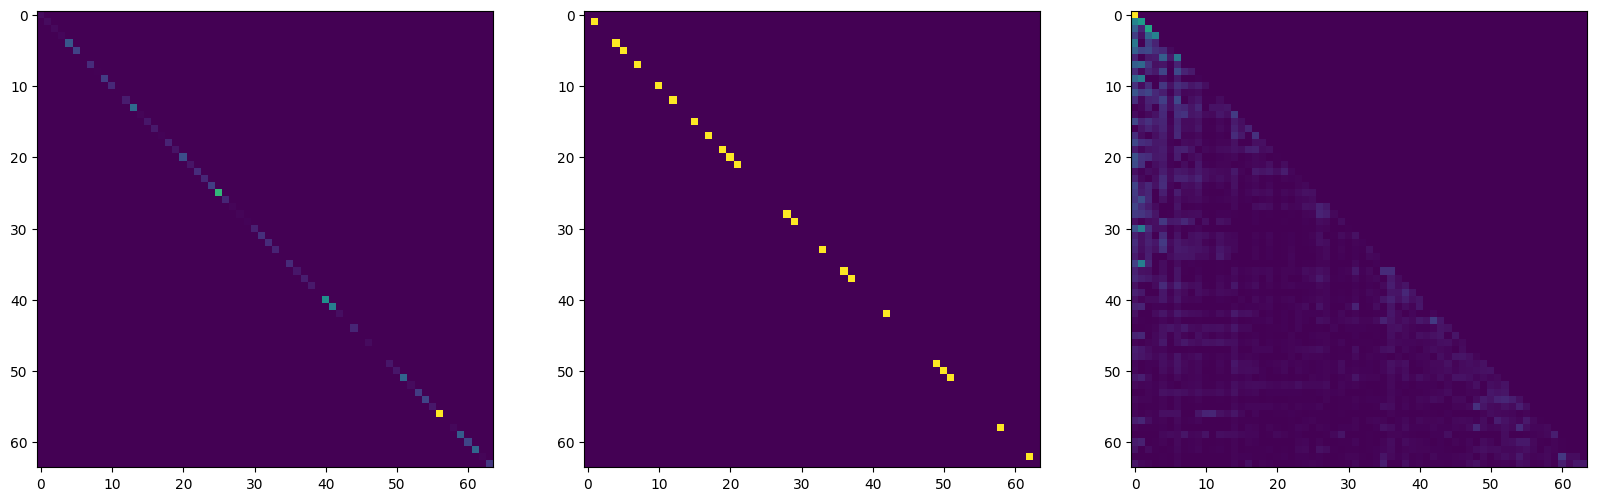

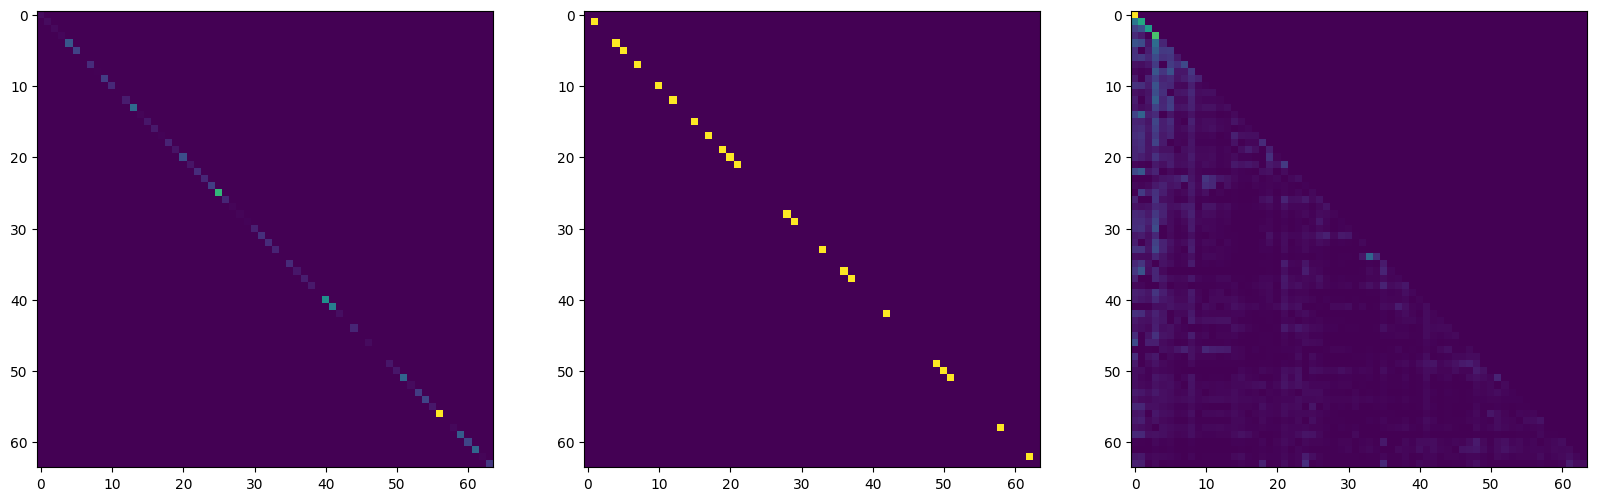

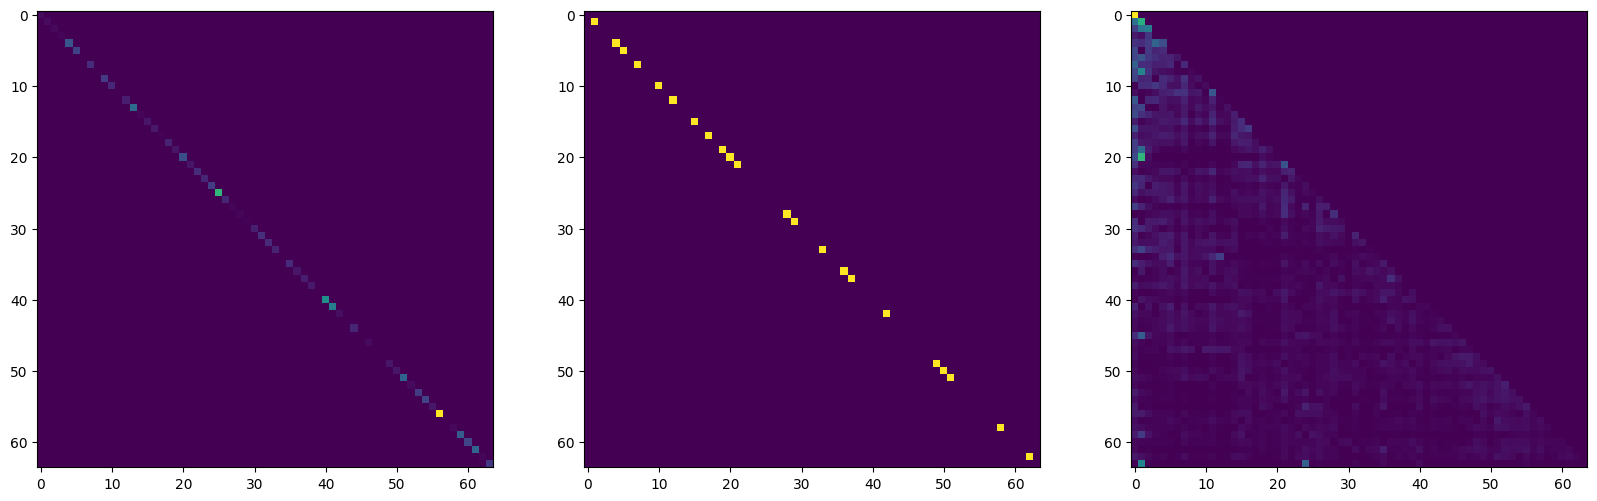

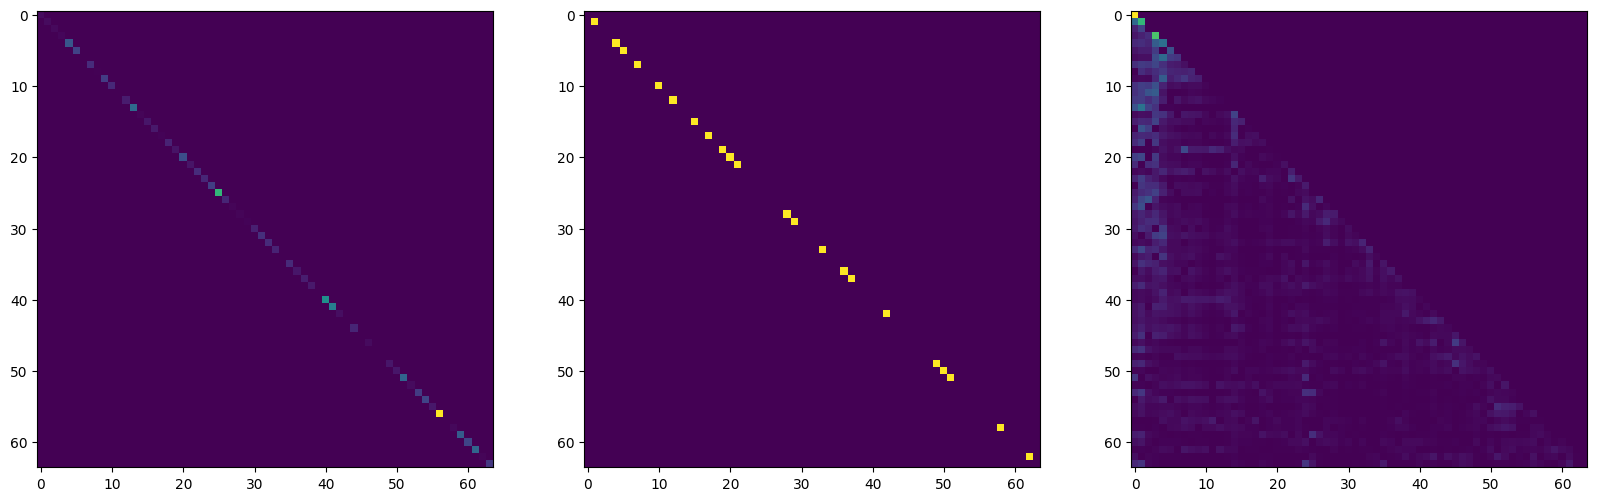

In [23]:
l=0
for i in range(5):
    plt.figure(figsize=(20, 80))
    plt.subplot(1, 3, 3)
    plt.imshow(out.attentions[l][i,0].cpu().numpy())
    #plt.subplot(1, 4, 4)
    #plt.imshow(out.attentions[l][i,1].cpu().numpy())
    plt.subplot(1, 3, 1)
    plt.imshow((x[0,:,0]**2).diag().cpu().numpy())
    plt.subplot(1, 3, 2)
    plt.imshow(x[0,:,1].diag().cpu().numpy())
    plt.show()

In [24]:
h = out.hidden_states[0]

In [25]:
h = h.flatten(end_dim=1)

In [26]:
h.shape

torch.Size([32768, 128])

In [27]:
U, S, V = torch.svd(h)

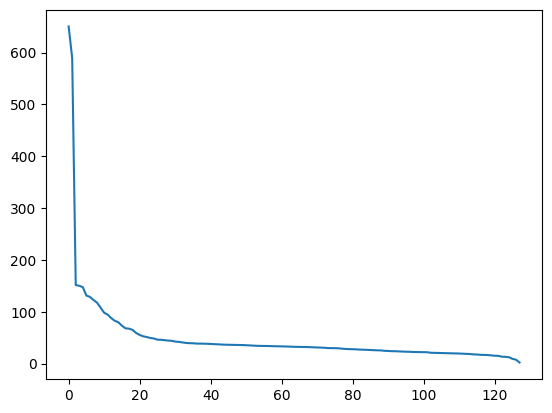

In [29]:
plt.plot(S.cpu().numpy())

In [281]:
np.corrcoef(V.T[0].cpu().numpy(), W[:-1,0])[1,0]

-0.0019739345273138025

In [268]:
W.shape

(129, 1)